In [121]:
import os
import json
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import chain
from tqdm import tqdm
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
from skimage import morphology, filters, measure
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt


Strategy
- For each scan, determine max_normal_hu, min_max_abnormal_hu. If max_normal_hu>min_max_abnormal_hu, filter out normal slices whose max_hu > min_max_abnormal_hu, and <mask> abnormal slices whose max_hu < max_normal_hu.

In [ ]:
DIR_PELVIS = os.path.join(os.getcwd(), "..", "data", "Task1", "pelvis")
list_pelvis_image_dir = [os.path.join(DIR_PELVIS, f) for f in os.listdir(DIR_PELVIS) if f.startswith("1P")]

DIR_LABELS = os.path.join(os.getcwd(), "..", "labels")
FILE_MISSING = os.path.join(DIR_LABELS, "missing_Ömer.txt")
LABELS_RAW = os.path.join(DIR_LABELS, "labels_raw.json")

DELTA=250

In [123]:
examples = [
    ("1PA133",74,82,"Bright spots on CT, black spots on MR."),
    ("1PA136",100,121,"Articfat due two metal nail in spine."),
    ("1PA147",45,53,"Bright spots on CT, hard to tell on MR."),
    ("1PA151",46,54,"Some bright spots visible (local radiotherapy with implants) in CT difficult to spot in MR."),
    ("1PA152",56,68,"Weird bright short little lines in CT, MR shows black spots. Not as bright as other cases."),
    ("1PA169",8,82,"OOD due to hip implant.")
]

In [ ]:
class MetalArtifactDetector:
    def __init__(self, metric='f1'):
        """
        metric: ('f1', 'youden', 'balanced_acc', 'recall', 'precision', 'accuracy')
        """
        self.metric = metric
        self.tau_global = None
        self.tau_map = {}


    @staticmethod
    def _confusion_binary(y_true, y_pred):
        y_true = np.asarray(y_true, dtype=np.uint8)
        y_pred = np.asarray(y_pred, dtype=np.uint8)
        tp = int(np.sum((y_true == 1) & (y_pred == 1)))
        tn = int(np.sum((y_true == 0) & (y_pred == 0)))
        fp = int(np.sum((y_true == 0) & (y_pred == 1)))
        fn = int(np.sum((y_true == 1) & (y_pred == 0)))
        return tp, fp, fn, tn

    @staticmethod
    def _metrics_from_cm(tp, fp, fn, tn, eps=1e-9):
        prec = tp / (tp + fp + eps)
        rec  = tp / (tp + fn + eps)
        f1   = 2 * prec * rec / (prec + rec + eps)
        tpr  = rec
        tnr  = tn / (tn + fp + eps)
        bal_acc = 0.5 * (tpr + tnr)
        youden  = tpr + tnr - 1.0
        acc     = (tp + tn) / (tp + fp + fn + tn + eps)
        return {
            "precision": prec, "recall": rec, "f1": f1,
            "balanced_acc": bal_acc, "youden": youden, "accuracy": acc
        }

    @staticmethod
    def _norm01(x, hu_window=None, clip_quantiles=None, eps=1e-6):
        x = np.asarray(x, dtype=float)
        if hu_window is not None:
            lo, hi = hu_window
            x = np.clip(x, lo, hi)
        elif clip_quantiles is not None:
            qlo, qhi = clip_quantiles
            lo = np.percentile(x, qlo*100.0)
            hi = np.percentile(x, qhi*100.0)
            x = np.clip(x, lo, hi)
        mn, mx = x.min(), x.max()
        if mx - mn < eps:
            return np.zeros_like(x)
        return (x - mn) / (mx - mn + eps)

    def score_volume_hu(self, vol, scan_id="scan1", slice_axis=0):
        """return max HU for each slice"""
        vol_z = np.moveaxis(vol, slice_axis, 0)  # (Z,H,W)
        z, h, w = vol_z.shape
        slice_max = np.max(vol_z.reshape(z, -1), axis=1)
        return pd.DataFrame({
            "scan_id": scan_id,
            "slice_idx": np.arange(z),
            "slice_max_hu": slice_max.astype(float),
        })

    def pick_global_tau_by_hu(self, df, metal_slices=None,
                              label_col='label', hu_col='slice_max_hu'):
        """
        global_tau = max(max_normal_hu, min_max_abnormal_hu)
        """
        if metal_slices is None:
            if label_col not in df.columns:
                raise ValueError("Need metal_slices or df[label_col].")
            labels = df[label_col].values.astype(int)
            pos_idx = np.where(labels == 1)[0]
            neg_idx = np.where(labels == 0)[0]
        else:
            sl = df["slice_idx"].values
            pos_mask = np.isin(sl, np.asarray(metal_slices, dtype=int))
            pos_idx = np.where(pos_mask)[0]
            neg_idx = np.where(~pos_mask)[0]

        vals = df[hu_col].values.astype(float)

        max_normal_hu = float(vals[neg_idx].max()) if len(neg_idx) > 0 else -np.inf
        min_max_abnormal_hu = float(vals[pos_idx].min()) if len(pos_idx) > 0 else np.inf

        global_tau = max(max_normal_hu, min_max_abnormal_hu)
        self.tau_global = global_tau
        return global_tau, {
            "max_normal_hu": max_normal_hu,
            "min_max_abnormal_hu": min_max_abnormal_hu
        }

    def apply_tau_by_hu(self, df, hu_col='slice_max_hu'):
        """classify slices based on HU values"""
        if self.tau_global is None or not np.isfinite(self.tau_global):
            raise ValueError("Global tau not set. Run pick_global_tau_by_hu first.")
        out = df.copy()
        out["pred"] = (out[hu_col].values >= self.tau_global).astype(np.uint8)
        return out

    def evaluate(self, df, label_col='label', pred_col='pred', scan_col='scan_id'):
        # slice-level
        tp, fp, fn, tn = self._confusion_binary(df[label_col].values, df[pred_col].values)
        sl = self._metrics_from_cm(tp, fp, fn, tn)
        sl.update(dict(tp=tp, fp=fp, fn=fn, tn=tn))

        # scan-level: 任一 slice 阳性即阳性
        scan_true = df.groupby(scan_col, sort=False)[label_col].max().values
        scan_pred = df.groupby(scan_col, sort=False)[pred_col].max().values
        tp, fp, fn, tn = self._confusion_binary(scan_true, scan_pred)
        sc = self._metrics_from_cm(tp, fp, fn, tn)
        sc.update(dict(tp=tp, fp=fp, fn=fn, tn=tn))
        return {"slice_level": sl, "scan_level": sc}


    def extract_mask_volume(self, vol, tau, slice_axis=0):
        return (vol >= tau).astype(np.uint8)

    def postprocess_mask(self, mask2d, min_hole_size=20, smooth=True, disk_size=3):
        mask = mask2d.astype(bool)

        # 1) fill in small holes
        mask = morphology.remove_small_holes(mask, area_threshold=min_hole_size)

        # 2) smooth boundaries
        if smooth:
            selem = morphology.disk(disk_size)
            mask = morphology.binary_opening(mask, selem)
            mask = morphology.binary_closing(mask, selem)

        return mask.astype(np.uint8)

    def postprocess_mask_volume(self, mask_vol, slice_axis=0,
                                min_hole_size=20, smooth=True, disk_size=0):
        vol_z = np.moveaxis(mask_vol, slice_axis, 0)
        out_z = []
        for z in range(vol_z.shape[0]):
            out_z.append(self.postprocess_mask(vol_z[z],
                                               min_hole_size=min_hole_size,
                                               smooth=smooth,
                                               disk_size=disk_size))
        out = np.stack(out_z, axis=0)
        return np.moveaxis(out, 0, slice_axis)
    
    def show_ct_mask_mr(
        self, ct_vol, mr_vol, raw_mask_vol, post_mask_vol, slice_indices,
        slice_axis=0, suptitle="CT (raw vs postprocessed mask) & MR",
        ct_hu_window=None, ct_clip_quantiles=None,
        mr_clip_quantiles=None,
        fill_alpha=0.6, outline_width=1.5,
        raw_color=(0.0, 0, 1.0),   # blue
        post_color=(0.0, 1.0, 0.0), # green
        outline_color="red",
        figsize=(12, 3)
    ):
        if isinstance(slice_indices, int):
            slice_indices = [slice_indices]

        ct = np.moveaxis(ct_vol, slice_axis, 0)
        mr = np.moveaxis(mr_vol, slice_axis, 0)
        raw_mask = np.moveaxis(raw_mask_vol, slice_axis, 0)
        post_mask = np.moveaxis(post_mask_vol, slice_axis, 0)

        print(ct.shape, mr.shape, raw_mask.shape, post_mask.shape)
        assert ct.shape == mr.shape == raw_mask.shape == post_mask.shape, "Shapes must match"

        n = len(slice_indices)
        fig, axs = plt.subplots(n, 3, figsize=(figsize[0], figsize[1] * n))

        if n == 1:
            axs = np.expand_dims(axs, 0)

        for i, z in enumerate(slice_indices):
            ct_img = self._norm01(ct[z], hu_window=ct_hu_window, clip_quantiles=ct_clip_quantiles)
            mr_img = self._norm01(mr[z], clip_quantiles=mr_clip_quantiles)
            raw_mask_img = raw_mask[z].astype(bool)
            post_mask_img = post_mask[z].astype(bool)

            ct_img  = np.rot90(ct_img,  k=-1)
            mr_img  = np.rot90(mr_img,  k=-1)
            raw_mask_img  = np.rot90(raw_mask_img,  k=-1)
            post_mask_img = np.rot90(post_mask_img, k=-1)

            # CT + raw mask
            axs[i, 0].imshow(ct_img, cmap="gray")
            overlay_raw = np.zeros((*raw_mask_img.shape, 4), dtype=float)
            r, g, b = raw_color
            overlay_raw[raw_mask_img] = [r, g, b, float(fill_alpha)]
            axs[i, 0].imshow(overlay_raw)
            contours = measure.find_contours(raw_mask_img, level=0.5)
            for contour in contours:
                axs[i, 0].plot(contour[:, 1], contour[:, 0], color=outline_color, linewidth=outline_width)
            axs[i, 0].set_title(f"Raw Mask+CT z={z}")
            axs[i, 0].axis("off")

            # CT + postprocessed mask
            axs[i, 1].imshow(ct_img, cmap="gray")
            overlay_post = np.zeros((*post_mask_img.shape, 4), dtype=float)
            r, g, b = post_color
            overlay_post[post_mask_img] = [r, g, b, float(fill_alpha)]
            axs[i, 1].imshow(overlay_post)
            contours = measure.find_contours(post_mask_img, level=0.5)
            for contour in contours:
                axs[i, 1].plot(contour[:, 1], contour[:, 0], color=outline_color, linewidth=outline_width)
            axs[i, 1].set_title(f"Post Mask+CT z={z}")
            axs[i, 1].axis("off")

            # MR
            axs[i, 2].imshow(mr_img, cmap="gray")
            axs[i, 2].set_title(f"MR z={z}")
            axs[i, 2].axis("off")

        plt.suptitle(suptitle, fontsize=14)
        plt.tight_layout()
        plt.show()


tau: 1619.0 | info: {'max_normal_hu': 1619.0, 'min_max_abnormal_hu': 1087.0}
Slice-level: {'precision': 0.6666666664444444, 'recall': 0.24999999996875, 'f1': 0.36363636317355374, 'balanced_acc': 0.6214539006900739, 'youden': 0.24290780138014778, 'accuracy': 0.9530201342217919, 'tp': 2, 'fp': 1, 'fn': 6, 'tn': 140}
Scan-level : {'precision': 0.9999999989999999, 'recall': 0.9999999989999999, 'f1': 0.9999999984999999, 'balanced_acc': 0.49999999949999996, 'youden': -1.000000082740371e-09, 'accuracy': 0.9999999989999999, 'tp': 1, 'fp': 0, 'fn': 0, 'tn': 0}
(149, 428, 277) (149, 428, 277) (149, 428, 277) (149, 428, 277)


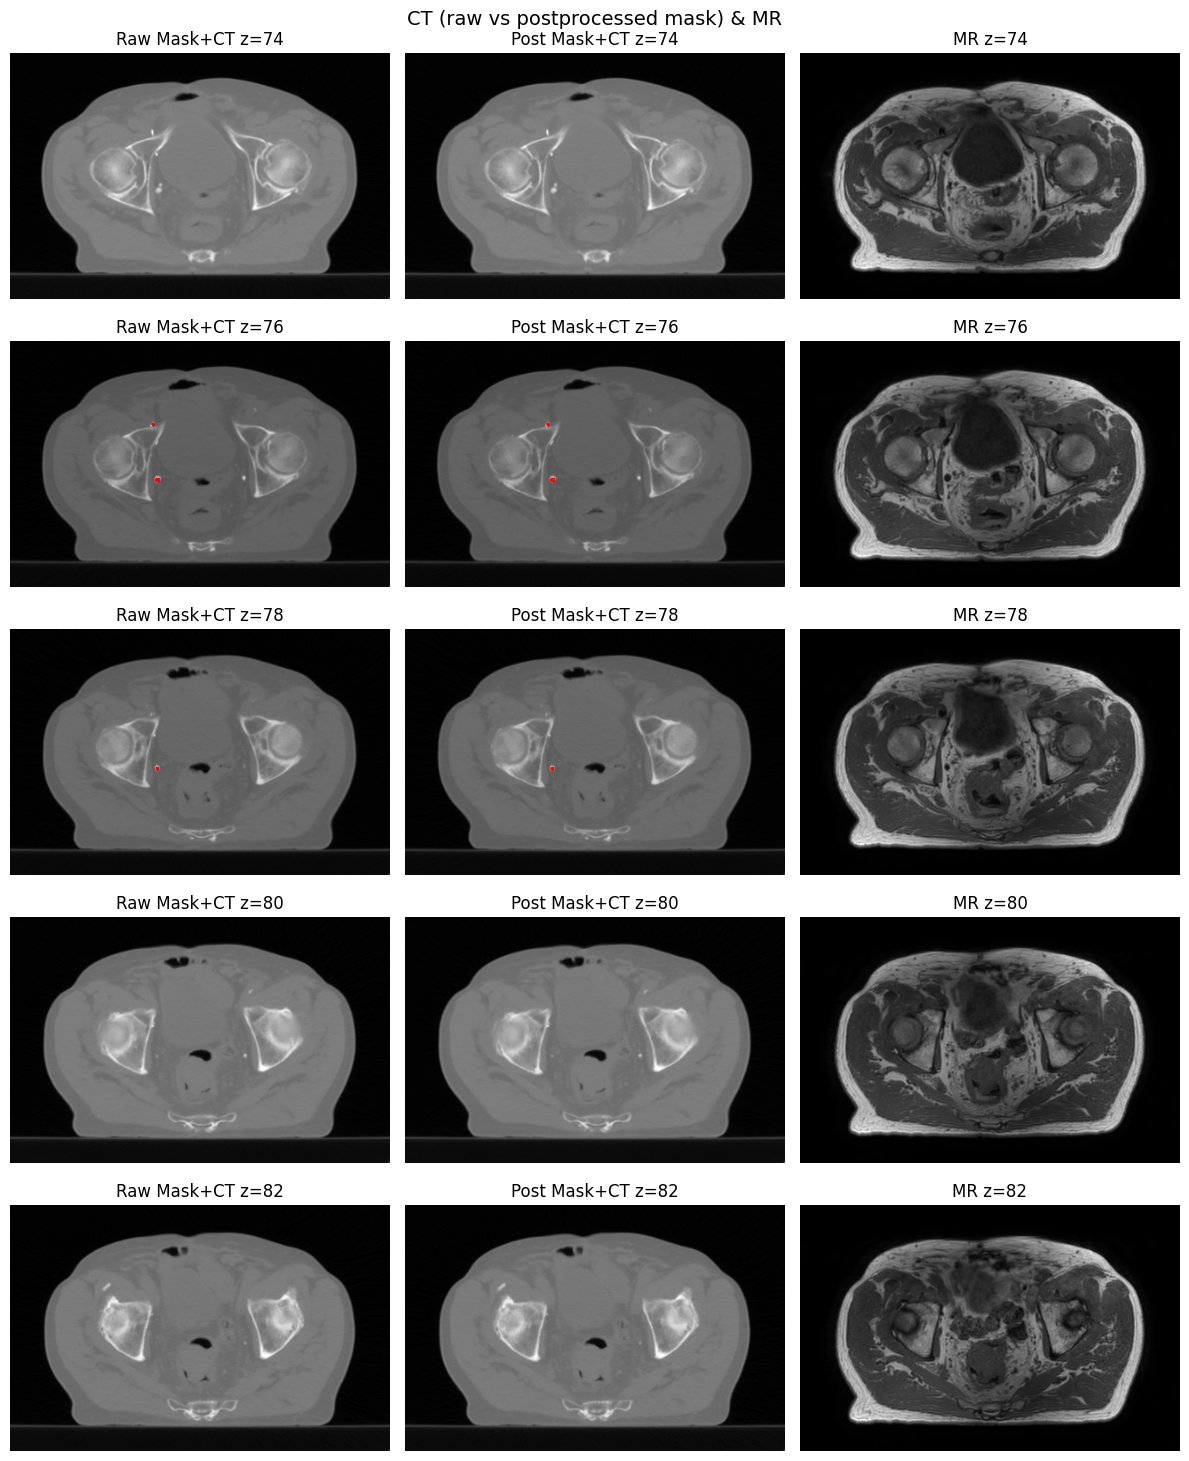

tau: 3000.0 | info: {'max_normal_hu': 3000.0, 'min_max_abnormal_hu': 1602.0}
Slice-level: {'precision': 0.9523809523356009, 'recall': 0.9523809523356009, 'f1': 0.9523809518356009, 'balanced_acc': 0.971239981113394, 'youden': 0.9424799622267881, 'accuracy': 0.9836065573689868, 'tp': 20, 'fp': 1, 'fn': 1, 'tn': 100}
Scan-level : {'precision': 0.9999999989999999, 'recall': 0.9999999989999999, 'f1': 0.9999999984999999, 'balanced_acc': 0.49999999949999996, 'youden': -1.000000082740371e-09, 'accuracy': 0.9999999989999999, 'tp': 1, 'fp': 0, 'fn': 0, 'tn': 0}
(122, 454, 268) (122, 454, 268) (122, 454, 268) (122, 454, 268)


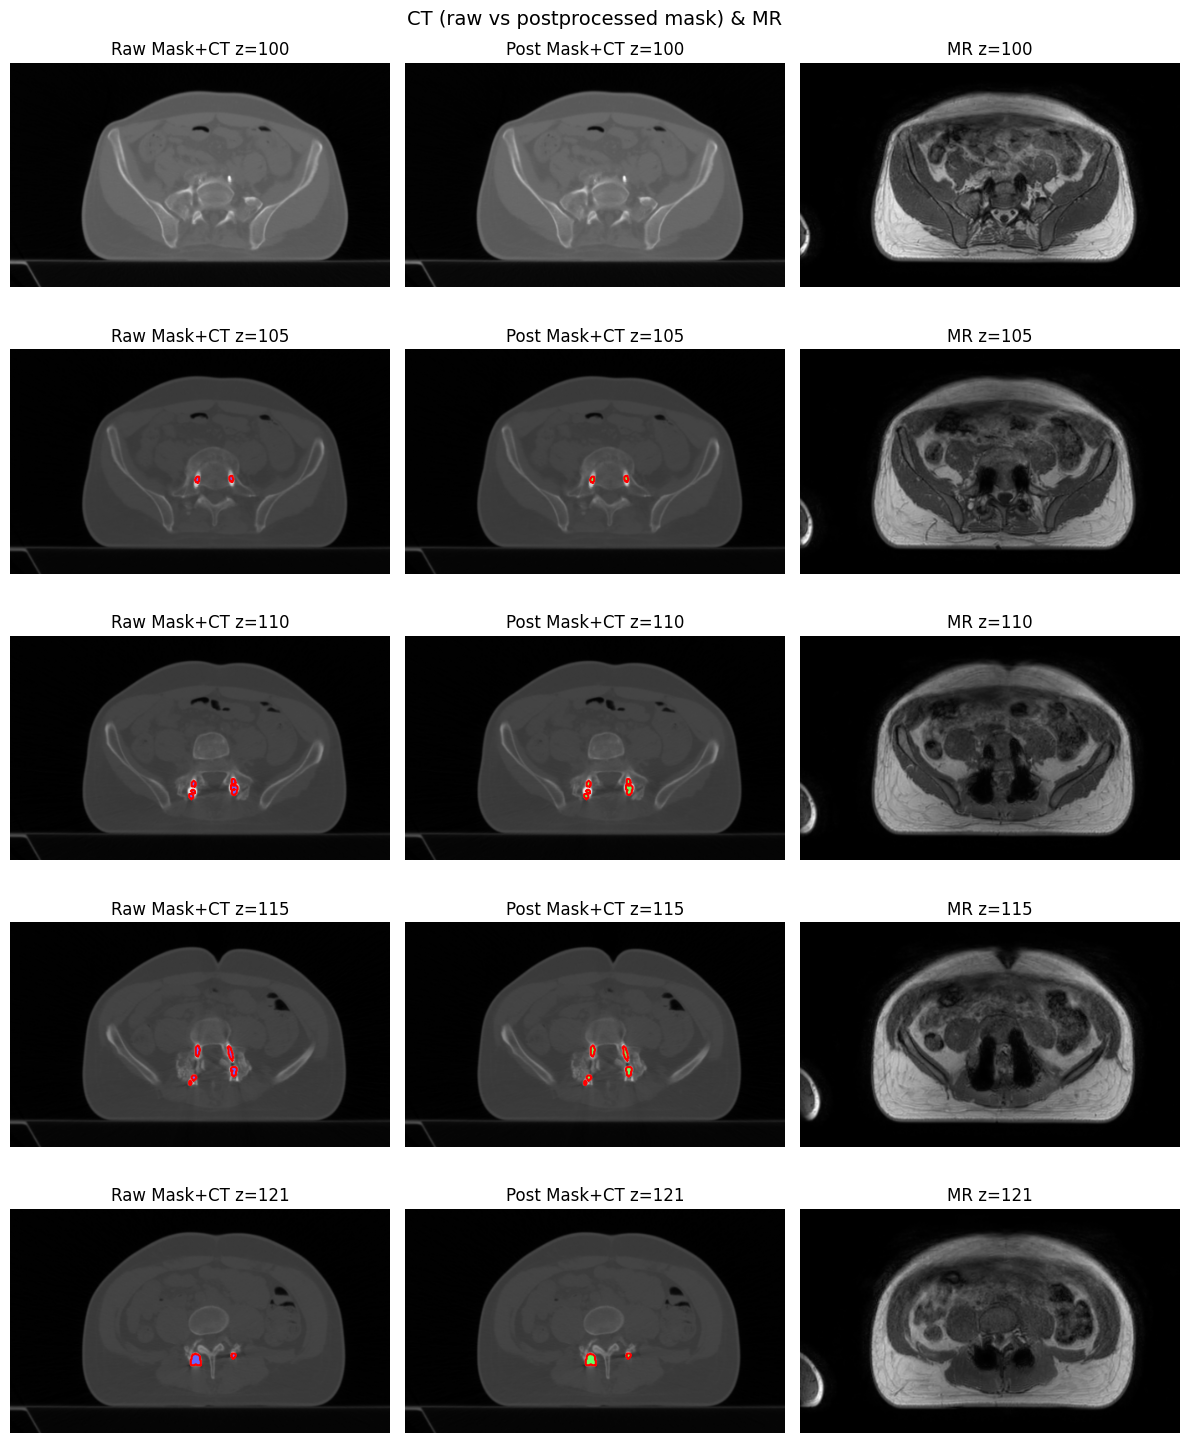

tau: 3000.0 | info: {'max_normal_hu': 3000.0, 'min_max_abnormal_hu': 3000.0}
Slice-level: {'precision': 0.11267605633644118, 'recall': 0.999999999875, 'f1': 0.2025316453824707, 'balanced_acc': 0.7418032786240426, 'youden': 0.4836065572480852, 'accuracy': 0.515384615380651, 'tp': 8, 'fp': 63, 'fn': 0, 'tn': 59}
Scan-level : {'precision': 0.9999999989999999, 'recall': 0.9999999989999999, 'f1': 0.9999999984999999, 'balanced_acc': 0.49999999949999996, 'youden': -1.000000082740371e-09, 'accuracy': 0.9999999989999999, 'tp': 1, 'fp': 0, 'fn': 0, 'tn': 0}
(130, 470, 323) (130, 470, 323) (130, 470, 323) (130, 470, 323)


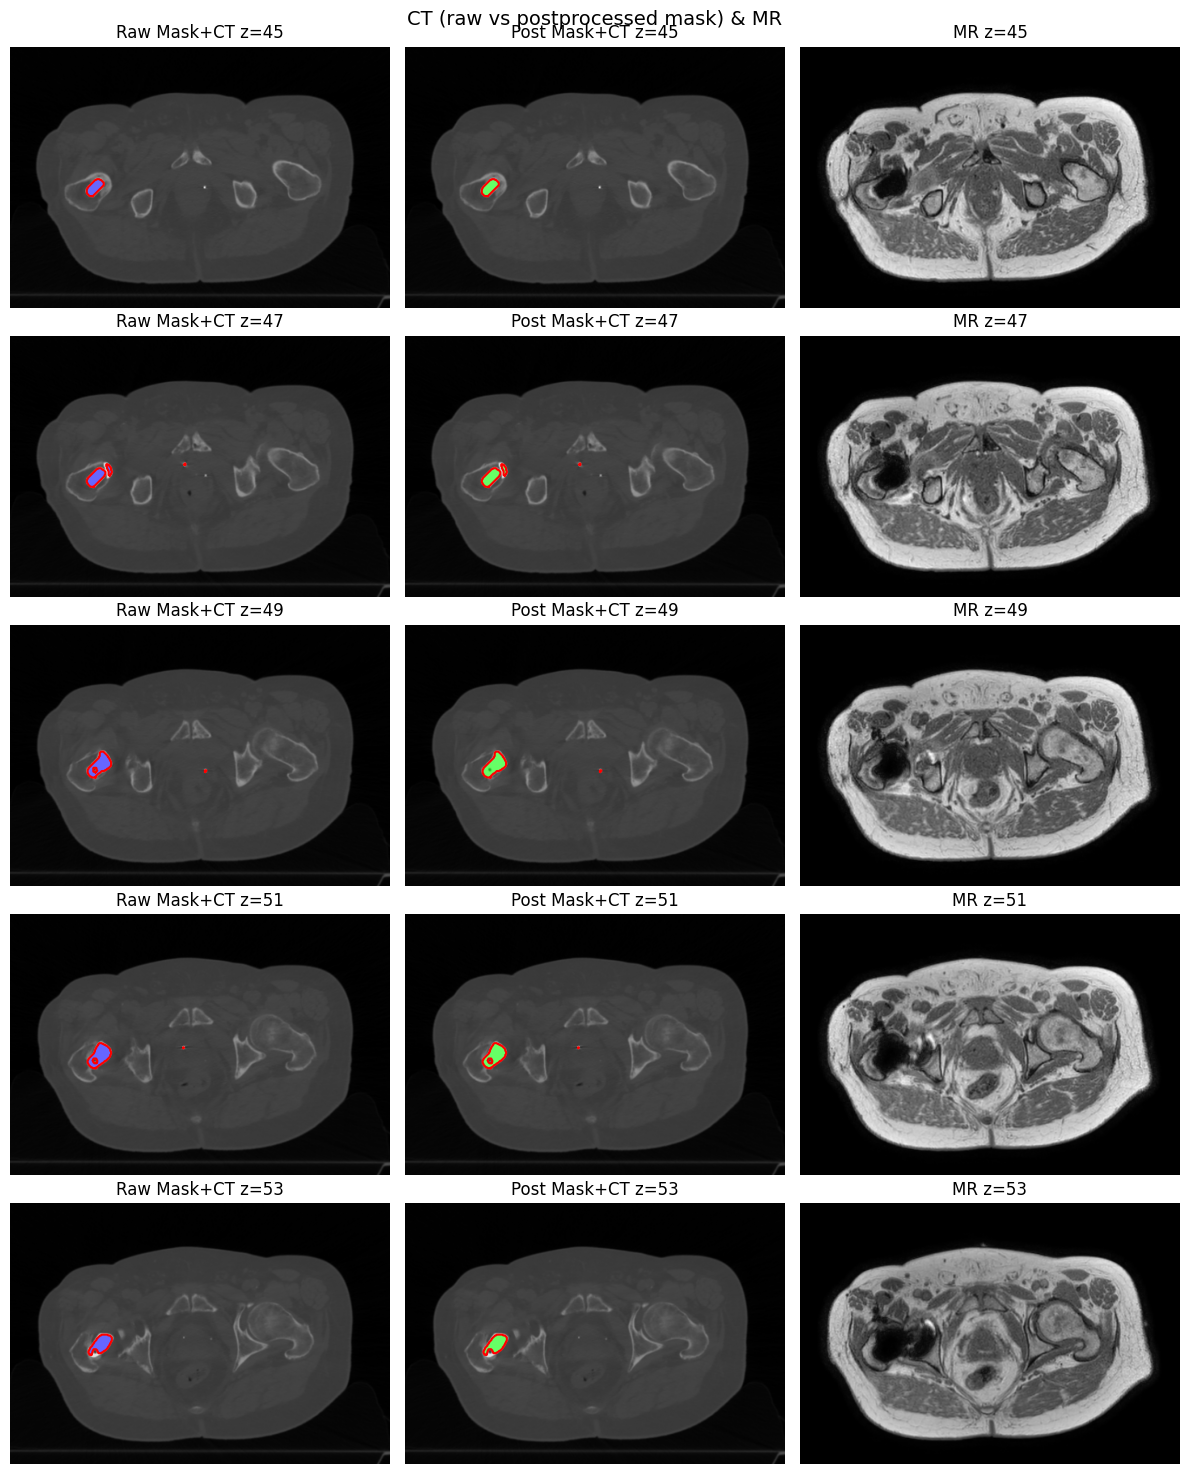

tau: 2575.0 | info: {'max_normal_hu': 2575.0, 'min_max_abnormal_hu': 1766.0}
Slice-level: {'precision': 0.7499999998125, 'recall': 0.374999999953125, 'f1': 0.4999999994722222, 'balanced_acc': 0.6838235293846778, 'youden': 0.36764705876935566, 'accuracy': 0.9583333333266784, 'tp': 3, 'fp': 1, 'fn': 5, 'tn': 135}
Scan-level : {'precision': 0.9999999989999999, 'recall': 0.9999999989999999, 'f1': 0.9999999984999999, 'balanced_acc': 0.49999999949999996, 'youden': -1.000000082740371e-09, 'accuracy': 0.9999999989999999, 'tp': 1, 'fp': 0, 'fn': 0, 'tn': 0}
(144, 472, 317) (144, 472, 317) (144, 472, 317) (144, 472, 317)


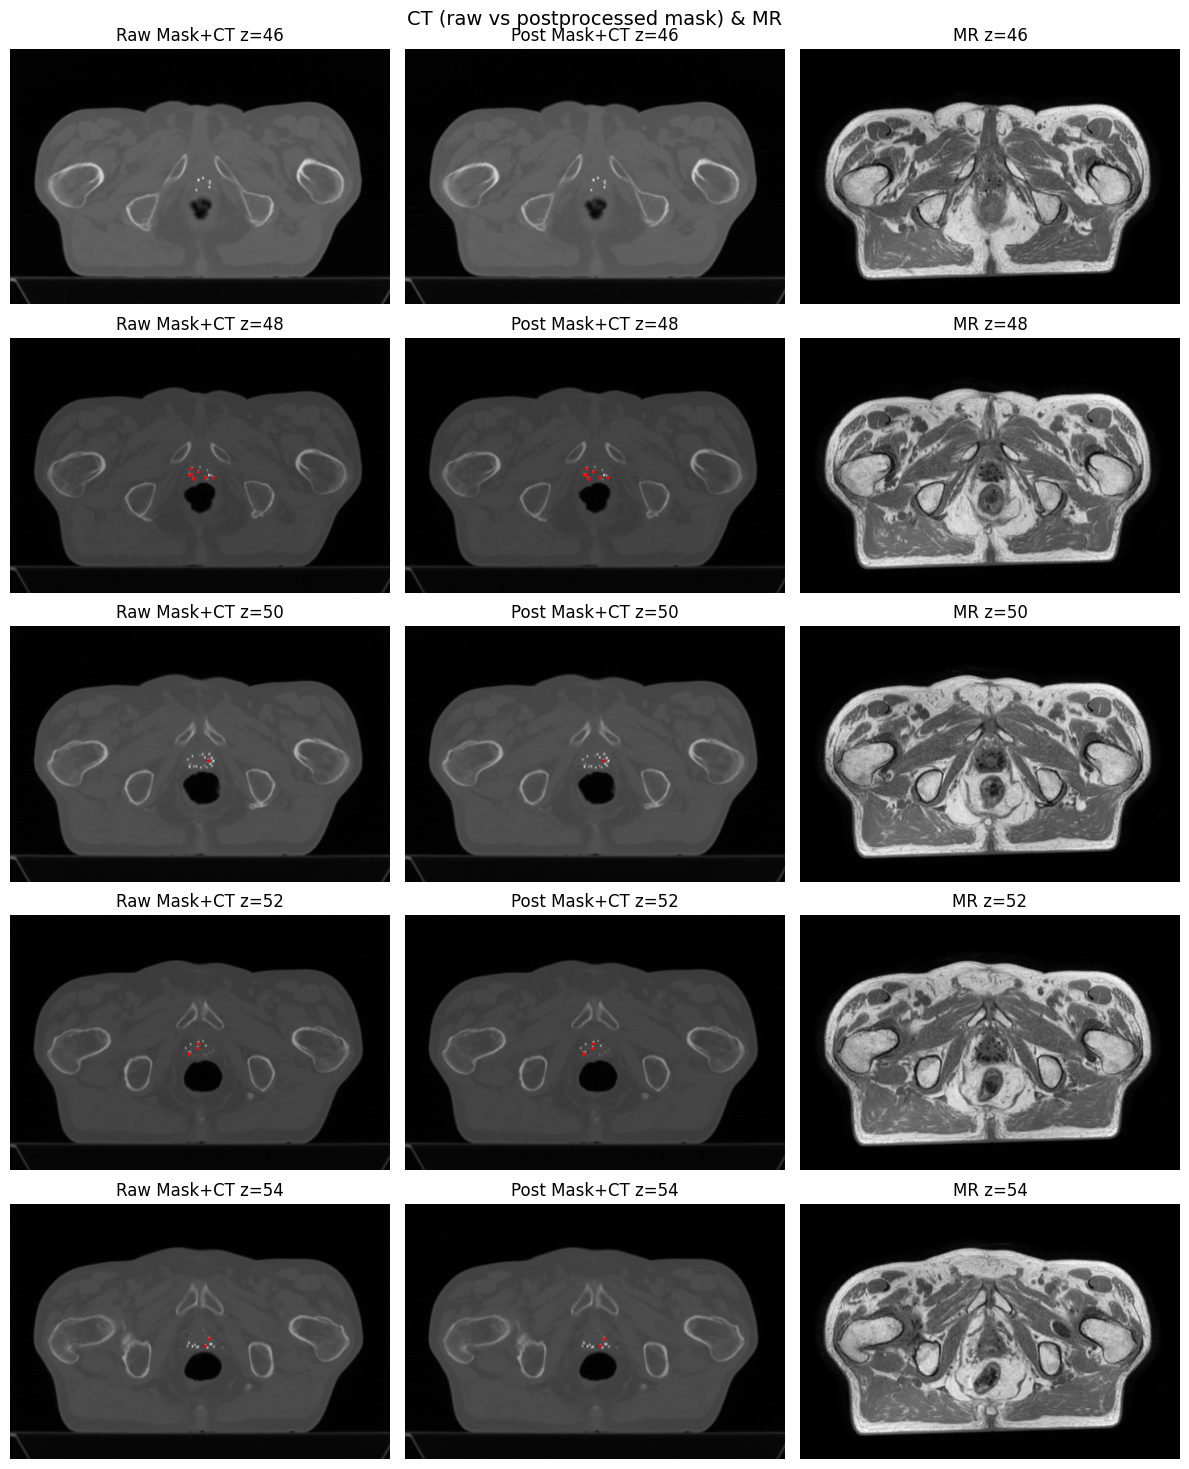

tau: 1485.0 | info: {'max_normal_hu': 1485.0, 'min_max_abnormal_hu': 1046.0}
Slice-level: {'precision': 0.7499999998125, 'recall': 0.24999999997916666, 'f1': 0.37499999957812497, 'balanced_acc': 0.6209349593351448, 'youden': 0.2418699186702895, 'accuracy': 0.9259259259190673, 'tp': 3, 'fp': 1, 'fn': 9, 'tn': 122}
Scan-level : {'precision': 0.9999999989999999, 'recall': 0.9999999989999999, 'f1': 0.9999999984999999, 'balanced_acc': 0.49999999949999996, 'youden': -1.000000082740371e-09, 'accuracy': 0.9999999989999999, 'tp': 1, 'fp': 0, 'fn': 0, 'tn': 0}
(135, 481, 309) (135, 481, 309) (135, 481, 309) (135, 481, 309)


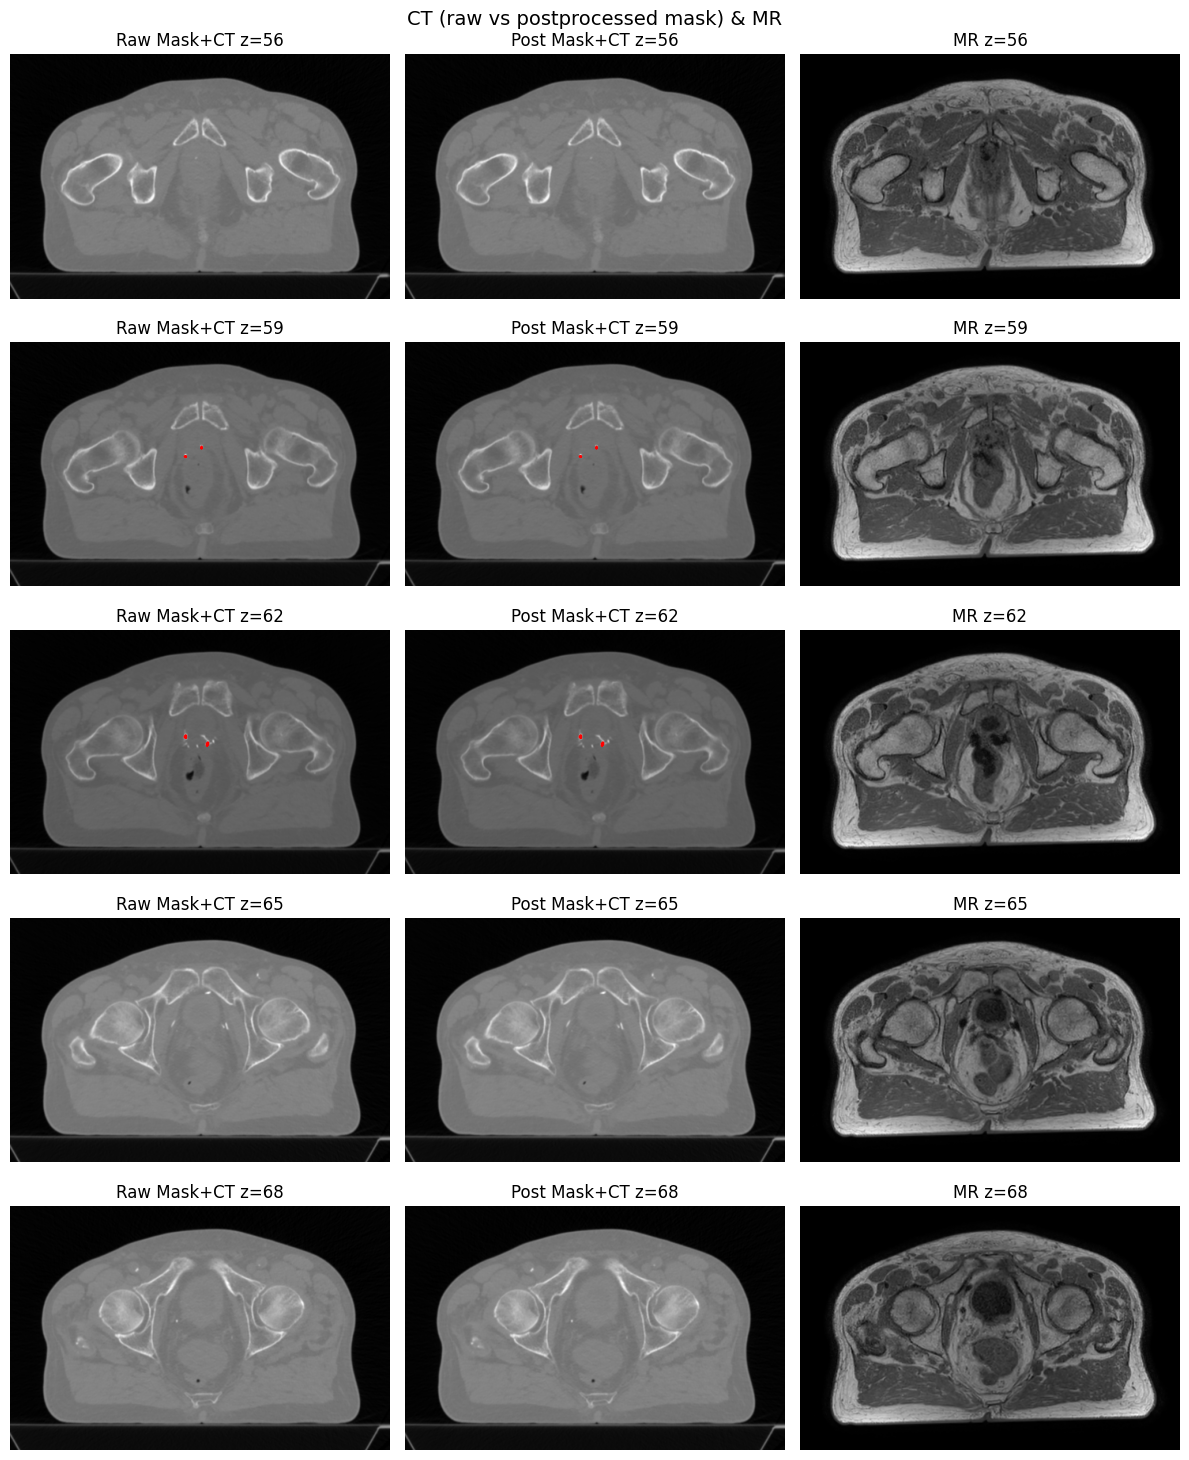

tau: 1483.0 | info: {'max_normal_hu': 1483.0, 'min_max_abnormal_hu': 1047.0}
Slice-level: {'precision': 0.9864864864731555, 'recall': 0.9864864864731555, 'f1': 0.9864864859731555, 'balanced_acc': 0.9828265765597115, 'youden': 0.965653153119423, 'accuracy': 0.9836065573689868, 'tp': 73, 'fp': 1, 'fn': 1, 'tn': 47}
Scan-level : {'precision': 0.9999999989999999, 'recall': 0.9999999989999999, 'f1': 0.9999999984999999, 'balanced_acc': 0.49999999949999996, 'youden': -1.000000082740371e-09, 'accuracy': 0.9999999989999999, 'tp': 1, 'fp': 0, 'fn': 0, 'tn': 0}
(122, 478, 338) (122, 478, 338) (122, 478, 338) (122, 478, 338)


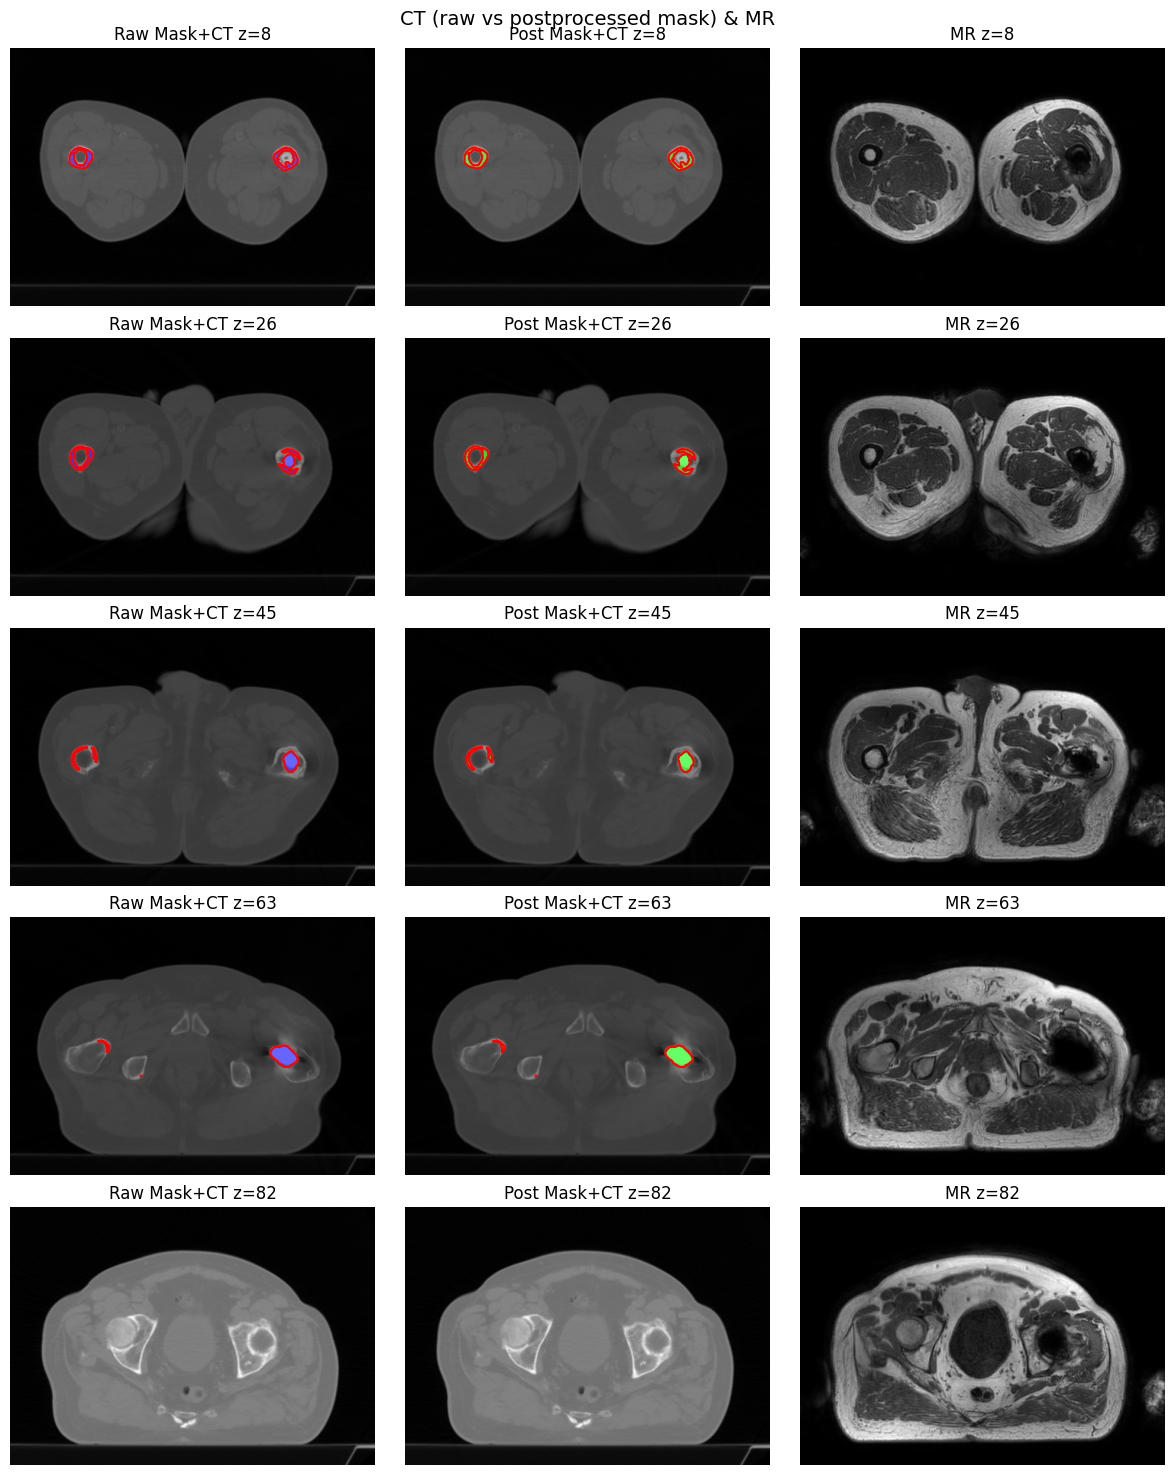

In [134]:
for example in examples:
    scan_id, start, end, desc = example
    path_scan = os.path.join(DIR_PELVIS, scan_id, "ct.nii.gz")
    path_mr = os.path.join(DIR_PELVIS, scan_id, "mr.nii.gz")
    ct_vol = nib.load(path_scan).get_fdata()
    mr_vol = nib.load(path_mr).get_fdata()
    anomaly_slices = list(range(start, end))

    det = MetalArtifactDetector()

    df_hu = det.score_volume_hu(ct_vol, scan_id=scan_id, slice_axis=2)
    df_hu["label"] = np.isin(df_hu["slice_idx"], anomaly_slices).astype(np.uint8)

    tau, info = det.pick_global_tau_by_hu(df_hu, label_col="label")
    print("tau:", tau, "| info:", info)
    tau -= DELTA

    mask_vol = (ct_vol >= tau).astype(np.uint8)

    df_hu_pred = det.apply_tau_by_hu(df_hu)
    metrics = det.evaluate(df_hu_pred, label_col="label", pred_col="pred", scan_col="scan_id")
    print("Slice-level:", metrics["slice_level"])
    print("Scan-level :", metrics["scan_level"])

    example_indices = np.linspace(start, end, 5, dtype=int)

    raw_mask = det.extract_mask_volume(ct_vol, tau, slice_axis=2)
    post_mask = det.postprocess_mask_volume(raw_mask, slice_axis=2, min_hole_size=25, smooth=True, disk_size=0)

    det.show_ct_mask_mr(ct_vol=ct_vol, mr_vol=mr_vol, 
                        raw_mask_vol=raw_mask, post_mask_vol=post_mask, 
                        slice_indices=example_indices, slice_axis=2)

In [131]:
class CTNormalizer:
    def __init__(self, mode="window", window=(1500, 4000), hu_clip=(-1000, 3500)):
        """
        mode : str
              - "slice-minmax" : min-max normalize to [0,1]
              - "scan-minmax"  : min-max normalize to [0,1] using the entire scan
              - "window"       : windowing (WW, WL), then scale to [0,1]
        window : tuple
            (WL, WW), only when mode="window" is used, default soft tissue window (WL=40, WW=400)
        hu_clip : tuple
            when mode="window", prevent extreme HU values by clipping to [-1000, 3000]
        """
        self.mode = mode
        self.window = window
        self.hu_clip = hu_clip

    def _normalize_slice_minmax(self, vol):
        vol_norm = np.zeros_like(vol, dtype=np.float32)
        for z in range(vol.shape[0]):
            vmin, vmax = vol[z].min(), vol[z].max()
            if vmax - vmin < 1e-6:
                vol_norm[z] = 0
            else:
                vol_norm[z] = (vol[z] - vmin) / (vmax - vmin + 1e-6)
        return vol_norm

    def _normalize_scan_minmax(self, vol):
        vmin, vmax = vol.min(), vol.max()
        return (vol - vmin) / (vmax - vmin + 1e-6)

    def _normalize_window(self, vol):
        WL, WW = self.window
        low, high = WL - WW/2, WL + WW/2
        vol_clip = np.clip(vol, self.hu_clip[0], self.hu_clip[1])
        vol_norm = (vol_clip - low) / (high - low + 1e-6)
        return np.clip(vol_norm, 0, 1)

    def transform(self, vol):
        vol = vol.astype(np.float32)
        if self.mode == "slice-minmax":
            return self._normalize_slice_minmax(vol)
        elif self.mode == "scan-minmax":
            return self._normalize_scan_minmax(vol)
        elif self.mode == "window":
            return self._normalize_window(vol)
        else:
            raise ValueError(f"Unknown mode: {self.mode}")

    def set_params(self, mode=None, window=None, hu_clip=None):
        if mode is not None:
            self.mode = mode
        if window is not None:
            self.window = window
        if hu_clip is not None:
            self.hu_clip = hu_clip